In [ ]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) 

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time
import scipy

# Data Pre-Processing

In [ ]:
#load attributes csv file
attribute = pd.read_csv("celeba.csv")

#"attribute" is a dictionary containing several attributes for each image
#attribute.keys()

In [ ]:
#let us list all the files in the image directory
path = "img_celeba_small"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant rows in attributes
attribute = attribute[:20000]

## Creating training and validation datasets

In [ ]:
# select first 15000 rows for training dataset
train = attribute[:15000]
train = train['Young']

# select last 5000 rows for test dataset
test = attribute[15000:20000]
test = test['Young']

In [ ]:
is_Young = train==1
is_Old = train==-1

# subset training set by young/old
train_y = train[is_Young] 
train_o = train[is_Old]

# select indices for prelim training set
onp.random.seed(0)
y_pindex = onp.random.choice(len(train_y), 2000, replace=False)
o_pindex = onp.random.choice(len(train_o), 2000, replace=False)

In [ ]:
# select prelim training & validation data
ptrain_y = train_y.iloc[y_pindex[:1500]] # need to test if this works
pval_y = train_y.iloc[y_pindex[1500:]]

ptrain_o = train_o.iloc[o_pindex[:1500]]
pval_o = train_o.iloc[o_pindex[1500:]]

# collate prelim training data (3k obs, 1.5k each class)
ptrain = ptrain_y.append(ptrain_o)
ptrain = ptrain.sort_index()

# collate prelim test data (1k obs, .5k each class)
pval = pval_y.append(pval_o)
pval = pval.sort_index()

## Loading images

The images were loaded in grayscale with an initial size of 100 by 100 pixels. The pixel intensity was then rescaled to [0,1]. To remove parts of the image irrelevant to a person's age (outside of the face), the images were cropped to only include the range [25:85, 20:80]. The final images used for analysis are 60 by 60 pixels.

In [ ]:
res = 100
#crop_dim = [25:85,20:80]

# load the images from the prelim training set
ntrain_img = len(ptrain)
ptrain_ind = ptrain.index.values
ptrain_img = onp.zeros((ntrain_img,60,60))

for k in range(ntrain_img):
    im = imageio.imread(os.path.join(path, all_img[ptrain_ind[k]])).astype(float)
    im = resize(im, (res,res))
    im = onp.mean(im, axis=2)
    im = im/255.
    im = im[25:85,20:80]
    ptrain_img[k,:,:] = im
    
# load the images from the prelim validation set
nval_img = len(pval)
pval_ind = pval.index.values
pval_img = onp.zeros((nval_img,60,60))

for k in range(nval_img):
    im = imageio.imread(os.path.join(path, all_img[pval_ind[k]])).astype(float)
    im = resize(im, (res,res))
    im = onp.mean(im, axis=2)
    im = im/255.
    im = im[25:85,20:80]
    pval_img[k,:,:] = im

In [ ]:
ptrain_img.size

In [ ]:
# test if the subsetting was successful
plt.figure(figsize=(10,2))
for k in range(20):
    im = ptrain_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = ptrain.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

In [ ]:
# test if the subsetting was successful
plt.figure(figsize=(10,2))
for k in range(20):
    im = pval_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = pval.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

`ptrain` is a 1x3000 array with the indicator values {-1, 1} for old and young. `ptrain_img` is a 3000 x 60 x 60 array that contains the relevant images for the preliminary training data. 

`ptest` is a 1x3000 array with the indicator values {-1, 1} for old and young. `ptest_img`is a 1000 x 60 x 60 array that contains the relevant images for the preliminary validation data. 

In [ ]:
data_train = ptrain_img.reshape(3000, 60*60)
y_train = ptrain.to_numpy(copy=True)

data_val = pval_img.reshape(1000, 60*60)
y_val = pval.to_numpy(copy=True)

# Optimisation

Logistic regression loss function with penalty: (penalty term not included for now)
$$ \frac{1}{N} \, \sum_{i=1}^N \log(1 + \exp(-y_i \, \langle \beta, x_i \rangle)) + \frac{1}{N} \| \beta \|^2$$

Logistic probability:
$$P(y=1 | x) = \frac{1}{1 + \exp(- \langle \beta, x \rangle)}$$

In [158]:
def prediction_single(beta, x):
    """ beta is a vector of dimension 10000, and x as well """
    proba = 1. / (1. + np.exp(-np.dot(beta, x)))
    return proba

#make a prediction on a whole dataset
prediction_data = jax.vmap(prediction_single, in_axes=(None,0))

def loss_single(beta,x,y):
    """
    beta: vector of dimension 100*100
    x: vector of dimension 100*100
    y: a number that equals -1 or 1
    """
    return np.log(1. + np.exp(-y * np.dot(beta, x)))

#compute the loss on. whole dataset
loss_dataset = jax.vmap(loss_single, in_axes=(None,0,0))

def loss(beta, data, y):
    """ compute the mean of all the individual losses """
    list_of_all_losses = loss_dataset(beta, data, y)
    return np.mean(list_of_all_losses) #+ np.mean(abs(beta))

grad_loss = jax.jit(jax.grad(loss))

def accuracy(beta, data, y):
    pred = prediction_data(beta, data)
    threshold = 0.5
    prediction_binary = (pred > 0.5).astype(int)  #equals 1 if pred > threshold and 0 otherwise
    prediction_sign = 2*(prediction_binary - 0.5) #equals 1 if pred > threshold and -1 otherwise
    return np.mean(prediction_sign == y)

In [159]:
D = 60*60
beta_init = onp.random.normal(0., scale = 1./onp.sqrt(D), size=D)

## Gradient Descent

In [ ]:
n_iter = 500
learning_rate = 0.01
loss_history = []
acc_train_list = []
acc_val_list = []

beta = onp.copy(beta_init)

for k in range(n_iter):
    gradient = grad_loss(beta, data_train, y_train)
    beta = beta - learning_rate * gradient
    current_loss = loss(beta, data_train, y_train)
    
    accuracy_train = accuracy(beta, data_train, y_train)
    accuracy_val = accuracy(beta, data_val, y_val) 
    
    acc_train_list.append(accuracy_train)
    acc_val_list.append(accuracy_val)
    if k % 50 == 0:
        print("Loss:{0:.3f} \t Accuracy: {1:.3f}% / {2:.3f}%".format(current_loss, \
                                             100*accuracy_train,\
                                             100*accuracy_val))
    loss_history.append(current_loss)

## L-BFGS

In [160]:
def loss_wrapper(beta):
    """ only one argument """
    return loss(beta, data_train, y_train)

grad_loss_wrapper = jax.jit(jax.grad(loss_wrapper))    

def gradient_wrapper(beta):
    """output is a numpy array"""
    return onp.array(grad_loss_wrapper(beta))

In [161]:
loss_train_history = []  #to save the loss trajectory
loss_val_history = []  #to save the loss trajectory
acc_train_list = []
acc_val_list = []
time_history = []  #to save the compute time

beta = onp.copy(beta_init)

def save_traj(beta):
    """ a function that saves a few statistics for later analysis"""
    loss_train = loss(beta, data_train, y_train)
    loss_val = loss(beta, data_val, y_val)
    timing = time.time() - start
    #print("Time:{0:3f} \t Loss(train):{1:.3f} \t Loss(val):{2:.3f}".format(timing, loss_train, loss_val))
    time_history.append(timing)
    loss_train_history.append(loss_train)
    loss_val_history.append(loss_val)
    
    accuracy_train = accuracy(beta, data_train, y_train)
    accuracy_val = accuracy(beta, data_val, y_val) 
    
    acc_train_list.append(accuracy_train)
    acc_val_list.append(accuracy_val)

#run LBFGS
start = time.time()
traj = scipy.optimize.minimize(fun = loss_wrapper, #functino to minimize
                                x0 = onp.array(beta_init), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=gradient_wrapper, #function that computes the gradient
                                callback=save_traj, #a function used to save some results for later pltting
                                options={"maxiter":100})  #maximum number of iteration

Text(0.5, 1.0, 'L-BFGS')

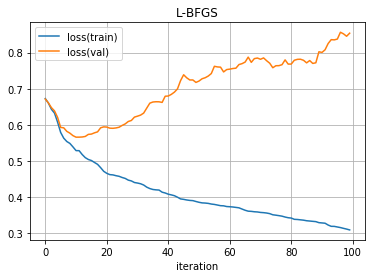

In [162]:
plt.plot(loss_train_history, label="loss(train)")
plt.plot(loss_val_history, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("iteration")
plt.title("L-BFGS")

Text(0.5, 1.0, 'L-BFGS')

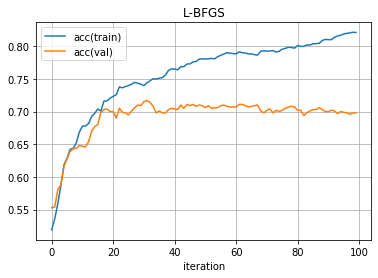

In [157]:
plt.plot(acc_train_list, label="acc(train)")
plt.plot(acc_val_list, label="acc(val)")
plt.legend()
plt.grid(True)
plt.xlabel("iteration")
plt.title("L-BFGS")

## Stochastic Gradient Descent + Momentum

In [171]:
n_epoch = 100
batch_size=100  #size of the mini-batch
beta = onp.copy(beta_init)
mov_avg_param = 0

learning_rate = 0.1
loss_train_history = []
loss_val_history = []

acc_train_list = []  #computed at the end of each epoch
acc_val_list = []    #computed at the end of each epoch

#initialize the gradient
gradient = grad_loss(beta, data_train, y_train)

start = time.time()
for epoch in range(n_epoch):
    #let us divide the learning by 2 every 10 epoch
    if epoch % 10 == 0 and epoch >= 1:
        learning_rate = learning_rate/2.
        
    for k in range(ntrain_img // batch_size):  #number of batch per epoch

        #first option
        #============
        #select at random "batch_size" random data point
        #index_ = onp.random.choice(train_data_size, batch_size, replace=False)

        #second option
        #============
        #consider the batches sequentially
        index_ = onp.arange(k*batch_size, (k+1)*batch_size) % ntrain_img
        gradient_local = grad_loss(beta, data_train[index_], y_train[index_])

        #moving average of the gradient
        gradient = gradient*mov_avg_param + (1-mov_avg_param)*gradient_local

        #gradient descent update
        beta = beta - learning_rate * gradient
    
    accuracy_train = accuracy(beta, data_train, y_train)
    accuracy_val = accuracy(beta, data_val, y_val) 
    acc_train_list.append(accuracy_train)
    acc_val_list.append(accuracy_val)
    
    loss_train = loss(beta, data_train, y_train)
    loss_val = loss(beta, data_val, y_val)
    loss_train_history.append(loss_train)
    loss_val_history.append(loss_val)
    
    timing = time.time() - start
    print("epoch:{0:.0f} \t time:{1:.0f} \t Loss(train):{2:.3f} \t Loss(val):{3:.3f}".format(epoch, 
                                                                                                  timing, 
                                                                                                  loss_train, 
                                                                                                  loss_val))

epoch:0 	 time:1 	 Loss(train):9.847 	 Loss(val):9.889
epoch:1 	 time:1 	 Loss(train):8.144 	 Loss(val):8.149
epoch:2 	 time:2 	 Loss(train):7.801 	 Loss(val):7.759
epoch:3 	 time:3 	 Loss(train):7.778 	 Loss(val):7.711
epoch:4 	 time:4 	 Loss(train):7.662 	 Loss(val):7.583
epoch:5 	 time:5 	 Loss(train):7.512 	 Loss(val):7.430
epoch:6 	 time:6 	 Loss(train):7.391 	 Loss(val):7.310
epoch:7 	 time:7 	 Loss(train):7.287 	 Loss(val):7.211
epoch:8 	 time:7 	 Loss(train):7.193 	 Loss(val):7.122
epoch:9 	 time:8 	 Loss(train):7.114 	 Loss(val):7.049
epoch:10 	 time:9 	 Loss(train):2.462 	 Loss(val):2.603
epoch:11 	 time:10 	 Loss(train):3.398 	 Loss(val):3.524
epoch:12 	 time:10 	 Loss(train):3.850 	 Loss(val):3.976
epoch:13 	 time:11 	 Loss(train):3.882 	 Loss(val):4.009
epoch:14 	 time:12 	 Loss(train):3.869 	 Loss(val):3.999
epoch:15 	 time:13 	 Loss(train):3.856 	 Loss(val):3.990
epoch:16 	 time:14 	 Loss(train):3.842 	 Loss(val):3.979
epoch:17 	 time:14 	 Loss(train):3.826 	 Loss(val):3

Text(0.5, 1.0, 'Stochastic Gradient Descent')

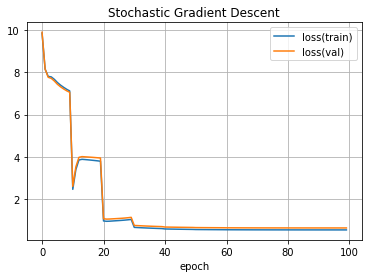

In [172]:
plt.plot(loss_train_history, label="loss(train)")
plt.plot(loss_val_history, label="loss(val)")
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("Stochastic Gradient Descent")

Text(0.5, 1.0, 'Stochastic Gradient Descent')

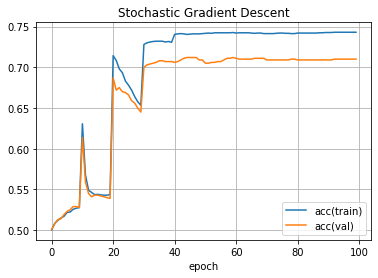

In [174]:
plt.plot(acc_train_list, label="acc(train)")
plt.plot(acc_val_list, label="acc(val)")
plt.legend()
plt.grid(True)
plt.xlabel("epoch")
plt.title("Stochastic Gradient Descent")